In [3]:
import sys
sys.path.append('../misc')

from MoviaBusDataset import MoviaBusDataset
import torch
from torch.nn import Linear, Sequential, ReLU, L1Loss, LSTM, BatchNorm1d, GRU
from torch.optim import Adam, lr_scheduler
import numpy as np
import random
from BaseNetwork import BaseNetwork

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
prev_timesteps = 6
prediction_steps = 6
batch_size = 25

train = MoviaBusDataset('../data/train', interpolation=True, 
                        prev_timesteps=prev_timesteps, 
                        max_future_time_steps=prediction_steps
                        )
validation = MoviaBusDataset('../data/validation', 
                       interpolation=True, 
                       prev_timesteps=prev_timesteps, 
                       max_future_time_steps=prediction_steps
                       )



In [15]:
train.remove_trend()
validation.remove_trend(train._historical_average)

In [52]:
train.normalize(individual_roads=False)
validation.normalize(train.mean, train.std)

In [147]:
num_timesteps = (prev_timesteps + 1)
num_roads = train[0]['target'].size()[1]

class EncDec(BaseNetwork):
    
    def __init__(self, hidden_size=100, num_layers=1):
        super().__init__(name="Sequence2Sequence")

        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.encoder = GRU(num_roads, hidden_size, batch_first=True, num_layers=num_layers, dropout=0.3)
        
        self.decoder = GRU(num_roads, hidden_size, batch_first=True, num_layers=num_layers, dropout=0.3)
        #self.activation = Sig()
        self.decoder_l1 = Linear(hidden_size, num_roads)
        
        self.BN = BatchNorm1d(7)
        
    def forward(self, x_in):
        x = x_in['data']
        target = x_in['target']
        
        n_batch = x.size()[0]
        #print(x.size())
        #x = self.BN(x)
        #torch.manual_seed(42)
        #hidden = (torch.zeros(self.num_layers, n_batch, self.hidden_size),#.cuda(),
        #          torch.zeros(self.num_layers, n_batch, self.hidden_size))#.cuda())
        hidden = torch.zeros(self.num_layers, n_batch, self.hidden_size)
        #Run previous timesteps through the encoder
        for t_i in range(prev_timesteps):
            _, hidden = self.encoder(x[:,t_i,:].view(-1,1,num_roads),hidden)
            
        
        #Use a GO symbol for the first input to the decoder
        x_t = torch.zeros(n_batch, 1, num_roads)
        
        use_teacher_forcing = True if random.random() < 0.5 and self.training else False
        predictions = []
        #Use the model to predict several timesteps into the future
        for t in range(prediction_steps):            
            #run through LSTM
            
            x_out, hidden = self.decoder(x_t.view(-1,1,num_roads),hidden)
            
            #apply activation and final outout layer
            x_out = self.decoder_l1((x_out))
                        
            prediction = x_out[:,0,:self.num_roads]
        
            predictions.append(prediction)
      
            #Use teacher forcing where we use the target at t to predict t+1
            if use_teacher_forcing:
                x_t = target[:,t,:]
            #Otherwise we use the prediction as the input 
            else:
                x_t = prediction
    
        return torch.stack(predictions,1)
    
    
net = EncDec()
optimizer_fun = lambda param : Adam(param, lr=1e-2, weight_decay=1e-6)
scheduler_fun = lambda optim : lr_scheduler.StepLR(optim, step_size=5, gamma=0.5)
criterion = L1Loss()

/home/jeppe/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [148]:
net.train_network(train, validation ,batch_size=10, 
                  num_epochs=30,
                  optimizer_fun=optimizer_fun,
                  #scheduler_fun=scheduler_fun,
                  criterion=criterion,
                  shuffle=True,
                 target_to_net=True)

epoch =  0  train loss = 0.453   validation loss = 0.465   output_std = 0.896
Model saved as Sequence2Sequence.pt
epoch =  2  train loss = 0.420   validation loss = 0.463   output_std = 0.862
Model saved as Sequence2Sequence.pt
epoch =  4  train loss = 0.415   validation loss = 0.459   output_std = 0.864
Model saved as Sequence2Sequence.pt
epoch =  6  train loss = 0.413   validation loss = 0.462   output_std = 0.865
epoch =  8  train loss = 0.411   validation loss = 0.461   output_std = 0.873
epoch = 10  train loss = 0.408   validation loss = 0.460   output_std = 0.878
epoch = 12  train loss = 0.407   validation loss = 0.459   output_std = 0.856
epoch = 14  train loss = 0.405   validation loss = 0.460   output_std = 0.878
epoch = 16  train loss = 0.403   validation loss = 0.462   output_std = 0.868
epoch = 18  train loss = 0.402   validation loss = 0.463   output_std = 0.865
epoch = 20  train loss = 0.401   validation loss = 0.462   output_std = 0.858
epoch = 22  train loss = 0.399   v

In [149]:
scores=[net.get_MAE_score(validation,timestep=i) for i in range(1,prediction_steps+1)]
print(scores)
print(sum(scores)/len(scores))

[1.5335077047348022, 1.538525104522705, 1.542020559310913, 1.549521803855896, 1.5527348518371582, 1.5612800121307373]
1.5462650060653687


<IPython.core.display.Javascript object>


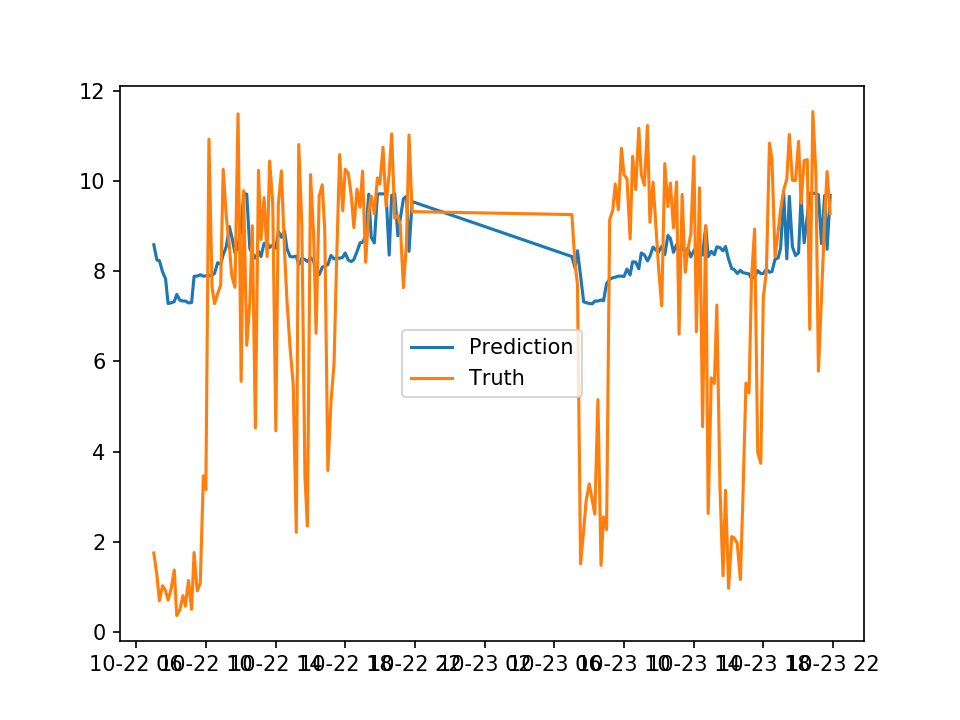

In [141]:
%matplotlib notebook

net.visualize_road(validation,timesteps=6, road=16)

* hidden = 100
* layers = 1
* no relu
* LSTM
* remove trend
* MAE = 
[1.5283441543579102, 1.532649278640747, 1.5375009775161743, 1.5411847829818726, 1.545353651046753, 1.5461335182189941]
1.5385277271270752


* hidden = 100
* layers = 1
* no relu
* LSTM
* normalize
* no scheduler
* lr = 1e-2
* 40 epochs
* MAE = 
[1.5076391696929932, 1.5325459241867065, 1.5416326522827148, 1.5472508668899536, 1.5494250059127808, 1.553267478942871]
1.5386268496513367


* hidden = 100
* layers = 1
* no relu
* LSTM
* normalize
* scheduler (10, 0.5)
* lr = 1e-2
* 100 epochs
* MAE =
[1.5083556175231934, 1.5279157161712646, 1.5325554609298706, 1.5382882356643677, 1.5445250272750854, 1.550295114517212]
1.533655862013499




* hidden = 100
* layers = 1
* no relu
* GRU
* normalize
* MAE = 
[1.5101897716522217, 1.5126105546951294, 1.5169870853424072, 1.52559232711792, 1.532387137413025, 1.5437188148498535]
1.5235809485117595

In [195]:
train[0]['data'][:,0]

tensor([-0.3719, -0.3719, -0.3484, -0.8721, -0.4520, -0.0063, -0.0582])

In [197]:
train[0]['target'][:,0]

tensor([-0.0908, -0.2940, -0.0293,  0.4993,  0.3600,  0.4941])

In [205]:
 (train[0]['time'])

tensor([1538374144., 1538374784., 1538375424., 1538375936., 1538376576.,
        1538377216.])

In [206]:
torch.tensor((train.dataframes[0].index[6:6+6+1]-datetime(1970, 1, 1)).total_seconds())

tensor([1538373632., 1538374144., 1538374784., 1538375424., 1538375936.,
        1538376576., 1538377216.])

In [209]:
datetime.fromtimestamp(1538373632, tz=pytz.utc)

datetime.datetime(2018, 10, 1, 6, 0, 32, tzinfo=<UTC>)

In [208]:
import pytz

In [190]:
from datetime import datetime
seconds_to_datetime = np.vectorize(datetime.fromtimestamp)
time = seconds_to_datetime(validation[0]['time'])
t=[(time[i].hour*60+round(time[i].minute,-1))/(22*60) for i in range(len(time))]
#time
time

array([datetime.datetime(2018, 10, 22, 8, 9, 4),
       datetime.datetime(2018, 10, 22, 8, 19, 44),
       datetime.datetime(2018, 10, 22, 8, 30, 24),
       datetime.datetime(2018, 10, 22, 8, 41, 4),
       datetime.datetime(2018, 10, 22, 8, 49, 36),
       datetime.datetime(2018, 10, 22, 9, 0, 16)], dtype=object)

In [188]:
validation.dataframes[-1]

LinkRef,103524893:266482296:1195317079,103524902:1242123651:1195317083,103524902:1242123670:3396253208,103524902:3396253208:1242123651,108233932:576722:4279694303,108233935:4279694307:1195317078,108233940:4459313602:4279694306,115678954:1306239263:576726,115678957:282678754:1306239519,115678974:10939966:282678730,...,87451616:4121323609:4929002366,87451616:4929002366:4121323609,87502481:4279694293:4279694295,87502481:4279694295:4279694293,87502482:1614362060:1614362080,87502482:1614362080:1614362060,87724803:20908158:20908159,87724803:20908158:792844,87724803:20908159:20908158,87724803:792844:20908158
Time,,,,,,,,,,,,,,,,,,,,,
2018-10-23 05:00:00,0.786514,-0.179708,0.169079,0.559741,0.363719,0.167473,-0.393585,-0.913065,-1.439575,0.194660,...,0.001458,1.271532,0.522891,0.588283,0.785872,1.085926,0.603590,-0.385775,0.349549,0.460854
2018-10-23 05:10:00,0.786514,-0.179708,0.169079,0.559741,0.363719,0.167473,-0.312269,-0.942834,-1.439575,0.067125,...,0.001458,1.271532,0.522891,0.778951,0.785872,0.858714,-0.198192,-0.385775,0.349549,-1.051432
2018-10-23 05:20:00,0.786514,-0.099627,-0.134856,0.357787,0.513499,-0.713444,-0.230953,-0.972603,-1.439575,-0.060411,...,-0.004474,1.271532,0.573065,0.969619,0.844061,0.631501,0.540934,-0.628254,0.322196,0.555023
2018-10-23 05:30:00,0.296276,-0.494922,0.213197,0.802409,0.663279,-1.594360,0.426004,-0.363746,-1.439575,-0.187946,...,-0.010406,0.921465,0.623239,1.111561,0.902250,1.227402,1.012272,-1.411728,0.417436,0.778104
2018-10-23 05:40:00,0.354821,-0.250787,-0.778828,0.666620,0.573560,-1.486539,0.119029,-0.937589,-1.439575,0.119029,...,-0.016338,0.571398,-1.237467,0.685895,0.829966,0.793781,0.549091,-1.337795,0.427281,-0.537928
2018-10-23 05:50:00,-0.303427,-0.006653,-0.547289,0.530832,0.164408,-1.378718,-0.422256,-0.270251,-1.439575,0.049329,...,-0.269510,1.173650,0.533519,-0.744432,0.698871,1.517471,0.564556,-1.263863,0.437126,0.390413
2018-10-23 06:00:00,0.328424,0.106744,-0.625811,0.576198,0.302621,-1.904945,-0.395562,-0.537928,-1.439575,-0.045581,...,0.244711,1.615432,1.008441,1.144257,1.100756,0.462019,0.360753,-1.409026,0.804533,0.121253
2018-10-23 06:10:00,0.960275,0.220140,-0.704333,0.621565,1.125967,-2.041153,0.654382,-1.188458,-1.439575,-0.140491,...,0.758931,1.521920,1.014956,1.178506,0.739900,1.488553,0.997584,-1.341128,0.044386,-0.993624
2018-10-23 06:20:00,-0.436993,0.520914,-0.776580,0.536283,1.329628,-2.080084,-0.012956,-0.627236,-1.439575,-0.256163,...,0.625818,0.966674,1.527852,-1.203236,1.645600,0.607774,0.769141,-0.544749,0.453068,-0.548160


In [143]:
a=train._historical_average.reset_index().pivot(index='TimeOfDay', columns='LinkRef',values='Speed')
a

LinkRef,103524893:266482296:1195317079,103524902:1242123651:1195317083,103524902:1242123670:3396253208,103524902:3396253208:1242123651,108233932:576722:4279694303,108233935:4279694307:1195317078,108233940:4459313602:4279694306,115678954:1306239263:576726,115678957:282678754:1306239519,115678974:10939966:282678730,...,87451616:4121323609:4929002366,87451616:4929002366:4121323609,87502481:4279694293:4279694295,87502481:4279694295:4279694293,87502482:1614362060:1614362080,87502482:1614362080:1614362060,87724803:20908158:20908159,87724803:20908158:792844,87724803:20908159:20908158,87724803:792844:20908158
TimeOfDay,,,,,,,,,,,,,,,,,,,,,
0.227273,0.857260,0.174347,-0.211521,0.644844,0.969217,-0.734047,0.333549,-0.766818,-1.167993,-0.146357,...,0.166269,0.878857,0.643649,0.555432,1.202580,0.398882,0.729432,-0.748613,0.762071,0.193429
0.234848,0.857260,0.174347,-0.211521,0.644844,0.911348,-0.760852,-0.058750,-0.837594,-1.201426,-0.183036,...,0.166269,0.878857,0.668411,0.741590,1.163661,0.770116,0.665809,-0.361898,0.762071,-0.107124
0.242424,0.833707,0.007573,-0.169318,0.521740,0.933767,-0.885979,0.366284,-0.939104,-1.234315,0.000226,...,0.351019,0.904763,0.826156,0.927748,1.102810,1.141351,1.072962,-0.225762,0.756296,0.645606
0.250000,0.788201,-0.033699,0.246955,0.570246,0.940763,-0.761503,0.283652,-0.825823,-1.265773,0.007028,...,0.558438,0.869702,0.817195,0.611710,1.010236,0.830205,0.873473,-0.686028,0.746921,0.151286
0.257576,0.796492,0.092945,-0.455207,0.571576,0.989387,-0.876343,0.179463,-1.047392,-1.389439,0.008467,...,0.765857,0.940530,0.394886,0.255294,1.034959,1.040297,0.878644,-0.593964,0.628504,0.143551
0.265152,0.779272,0.065221,0.096360,0.510437,0.927469,-0.848665,0.139818,-0.694918,-1.390256,-0.129125,...,0.668487,0.916697,0.535197,-0.979151,1.074759,1.130784,0.724348,-0.749260,0.727164,-0.888146
0.272727,0.847059,0.187468,0.047144,0.539443,0.893140,-0.833800,0.324289,-0.558319,-1.433934,0.040262,...,0.630383,0.994466,0.534043,0.199378,1.043606,0.986125,0.773632,-0.464727,0.803488,-0.534332
0.280303,0.895603,0.513392,-0.290574,0.614884,0.602895,-1.486049,0.265310,-1.128276,-1.416825,-0.081074,...,0.629761,0.928028,0.802986,0.452755,1.060000,0.898669,0.911874,-0.160933,0.460296,-0.469700
0.287879,1.026206,0.191682,-0.466211,0.523743,1.003233,-1.008690,0.308261,-0.750608,-1.341245,0.046859,...,0.341819,1.010591,0.809329,-0.556810,1.122626,0.585555,0.944542,-0.606207,0.684204,-0.306730


In [158]:
a[(a.index in t).all()]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [182]:
b=a[a.index.isin(t)].values
b[:,1]

array([ 0.12438424, -0.16387111,  0.06303245,  0.06278189,  0.0386174 ,
       -0.07009883])

In [213]:
train.std

3.3716079768969083